## Logistic Regression

The class <b>logistic regession</b> takes in inputs:
  
    path: string, path to the data
    split: float, split ratio
    shuffle: boolean, if True it shuffles the data
    weight_initializer: string, weight_initialization method
        if weight_initializer = 'uniform' then input low and high limits
    threshold: float, differentiating threshold (default = 0.5)
   
To train the model:
    Instantiate the object for the class
    Call the train method, which takes in the following inputs
        
        epochs: int, number of epochs
        learning_rate: float, learning rate for the model
        regularization: string, type of regularization to use
                        default: None
        regularization_factor: float, value of factor lambda

To test using the model:
    Call the test method which takes the inputs:
        X: the input vector
        
        returns Yhat the prediction by the model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
DATA = "" # Path to data
THRESHOLD = 0.5 

In [3]:
### Utility Functions to plot the data, calculate accuracy and split the dataset

def accuracy(Y_pred, Y_test):
    
    Y_pred = Y_pred.T
    Y_test = Y_test.T
    
    Y_pred[Y_pred >= 0.5] = 1
    Y_pred[Y_pred < 0.5] = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for (x, y) in zip(Y_pred, Y_test):
        if int(x) == int(y):
            if int(x) == 0:
                tn+=1
            else:
                tp+=1
        else:
            if int(x) == 1:
                fp += 1
            else:
                fn += 1
    
    acc = (tp+tn)/(tp+fp+tn+fn) * 100
    recall = tp/(tp+fn) * 100
    precision = tp/(tp+fp) * 100
    fscore = 2 * (precision*recall)/(precision+recall)
    
    return (acc, fscore)

def plot(err, ep, name):
    
    os.makedirs("plots", exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ep, err)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error (Loss)")
    plt.title("Loss vs Epochs "+ name)
    plt.savefig("./plots/"+name + ".png")
    plt.show()

In [4]:
# class to implement logistic regression

class LogisticRegression():
    def __init__(self, path, split=0.8, shuffle=True, weight_initializer='zeros', low=0, high=None, threshold=0.5):
        
        # process the data
        df = pd.read_csv(path)
        self.X, self.Y = self.preprocess(path)
        s = int(len(df) * split)
        self.X_test = self.X[:, s:]
        self.Y_test = self.Y[:, s:]
        self.X = self.X[:, :s]
        self.Y = self.Y[:, :s]
        
        
        self.num_features, self.num_examples = self.X.shape
        self.W = self.init_weight(weight_initializer, low, high)
        self.b = 0
        self.threshold = threshold
    
    def preprocess(self, path):
        with open(path, 'r') as f: 
            file = f.read().strip().split("\n")

        data = []
        for i in file:
            tmp = [float(j) for j in i.split(',')]
            data.append(tmp)

        data = np.array(data).astype(np.float64)
        X = data[:, :-1]
        for i in range(X.shape[1]):
            X[:, i] = (X[:, i]-np.mean(X[:, i]))/np.std(X[:, i])
        Y = data[:, -1].astype(int)
        
        return X.T, np.reshape(Y, newshape=(1, -1))
    
    def init_weight(self, init, low, high):
        # weight initializer
        possible_initializers = ['gaussian', 'uniform', 'zeros']
        
        if init.lower() in possible_initializers:
            if init.lower() == 'uniform':
                return np.random.random(size=(self.num_features, 1))
            elif init.lower() == 'gaussian':
                return np.random.randn(self.num_features, 1)
            elif init.lower() == 'zeros':
                return np.zeros((self.num_features, 1))                
        else:
            print("Wrong Initializer")
            return None
    
    def forward(self):
        yhat = self.sigmoid(np.dot(self.W.T, self.X) + self.b)
        return yhat
    
    def compute_cost(self, Yhat, regularization, lamda):
        cost = -(1/self.num_examples) * np.sum(self.Y*np.log(Yhat) + (1-self.Y)*np.log(1-Yhat))
        if regularization == 'L1':
            cost += -(1/self.num_examples)*np.sum(lamda*self.W)
        elif regularization == 'L2':
            cost += -(1/self.num_examples)*np.sum(((lamda*(self.W**2))/2))
        
        return cost
    
    def compute_gradients(self, Yhat, regularization, lamda):
        dw = (1/self.num_examples)*(np.dot(self.X, (Yhat-self.Y).T))
        if regularization == 'L1':
            dw += lamda*np.ones_like(self.W)
        elif regularization== 'L2':
            dw += lamda*self.W
        db = (1/self.num_examples)*np.sum(Yhat-self.Y)
        
        return dw, db
    
    def update_parameters(self, dw, db, learning_rate):
        self.W -= learning_rate*dw
        self.b -= learning_rate*db
    
    def sigmoid(self, X):
        return 1/(1+np.exp(-X))
    
    def train(self, epochs=100, learning_rate=0.01, regularization = None, regularization_factor=0.01, V=False):
        ep, err = [], []
        for epoch in range(epochs):
            
            Yhat = self.forward()
            cost = self.compute_cost(Yhat, regularization,regularization_factor)
            dw, db = self.compute_gradients(Yhat, regularization, regularization_factor)
            self.update_parameters(dw, db, learning_rate)
            
            if epoch%1000 == 999:
                if V:
                    print("Epoch: {} Cost: {}".format(epoch+1, cost))
                ep.append(epoch+1)
                err.append(cost)
        
        return ep, err
                    
    def predict(self, X):
        """
        """
        y_hat = self.sigmoid(np.dot(self.W.T, X) + self.b)
        return y_hat
    
    def evaluate(self, train = False):
        if train:
            acc, fscore = accuracy(self.predict(self.X), self.Y)
        else:
            acc, fscore = accuracy(self.predict(self.X_test), self.Y_test)
        return acc, fscore
    
    def get_params(self):
        print("+++++++++++++")
        print(self.W)
        print("+++++++++++++")

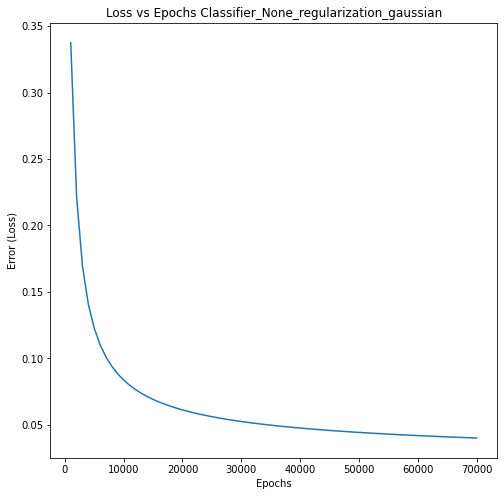

========== Train Statistics ===============
Accuracy:  98.72262773722628  F-Score:  97.94117647058825
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




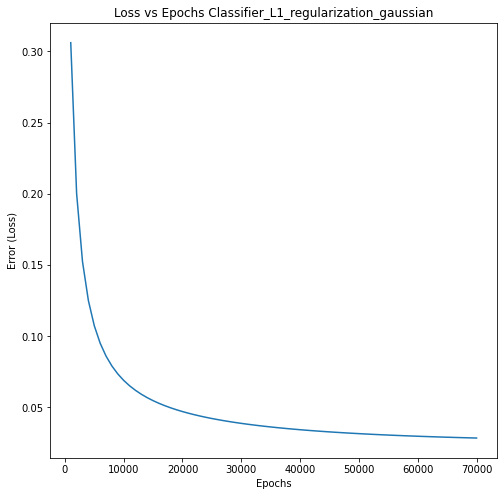

========== Train Statistics ===============
Accuracy:  98.8138686131387  F-Score:  98.07407407407406
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




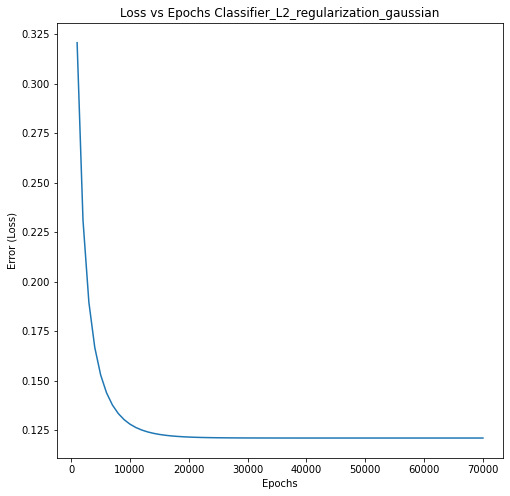

========== Train Statistics ===============
Accuracy:  97.71897810218978  F-Score:  96.274217585693
========== Test Statistics ===============
Accuracy:  97.10144927536231  F-Score:  98.52941176470588




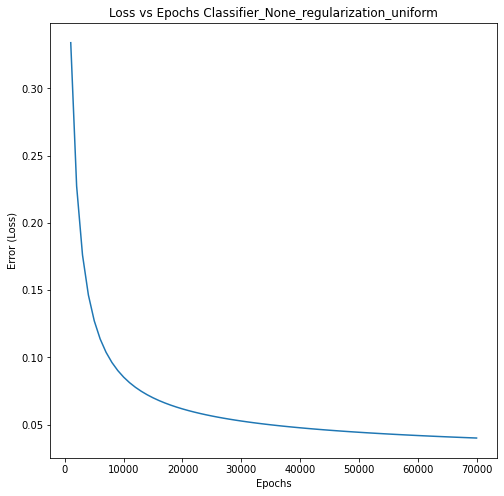

========== Train Statistics ===============
Accuracy:  98.72262773722628  F-Score:  97.94117647058825
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




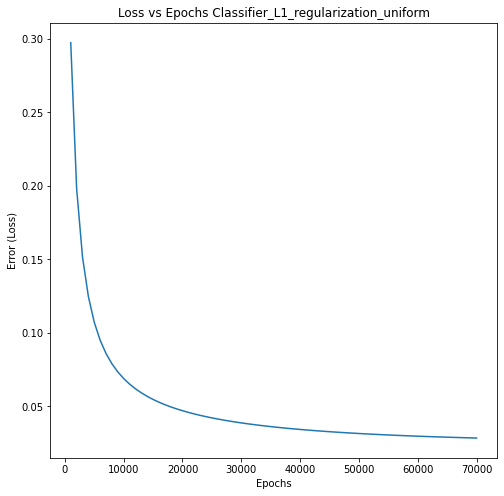

========== Train Statistics ===============
Accuracy:  98.8138686131387  F-Score:  98.07407407407406
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




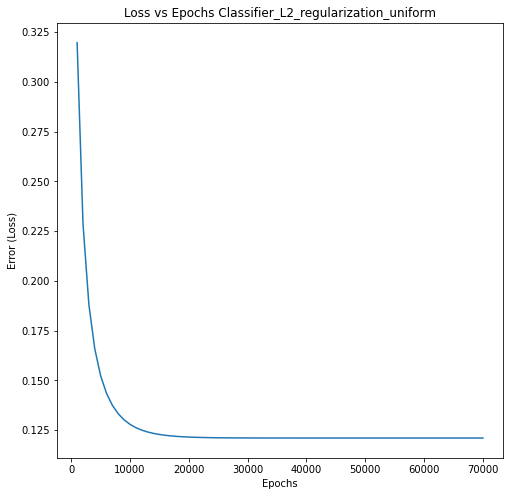

========== Train Statistics ===============
Accuracy:  97.71897810218978  F-Score:  96.274217585693
========== Test Statistics ===============
Accuracy:  97.10144927536231  F-Score:  98.52941176470588




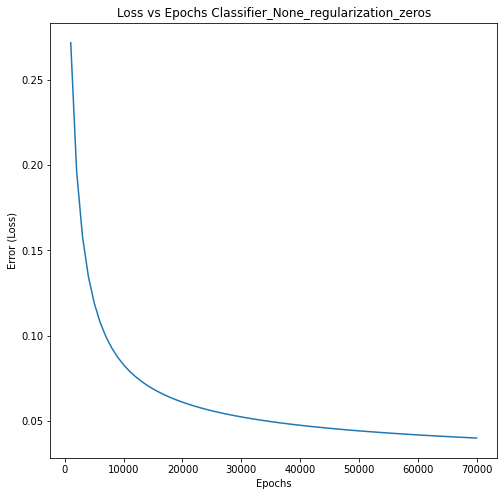

========== Train Statistics ===============
Accuracy:  98.72262773722628  F-Score:  97.94117647058825
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




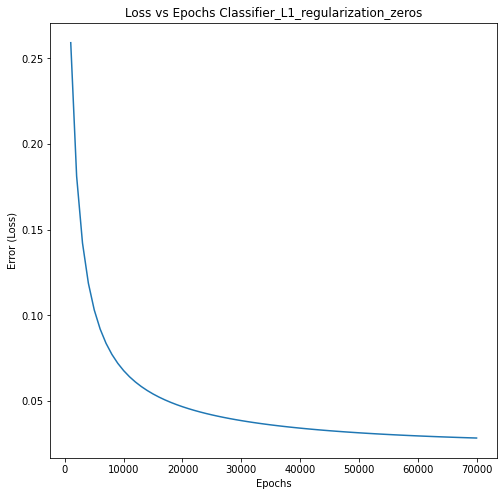

========== Train Statistics ===============
Accuracy:  98.8138686131387  F-Score:  98.07407407407406
========== Test Statistics ===============
Accuracy:  99.27536231884058  F-Score:  99.63636363636364




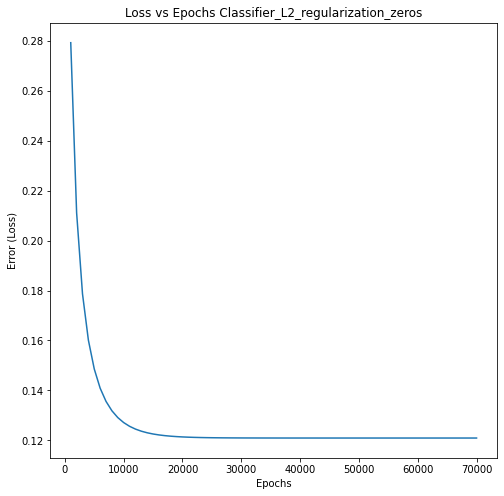

========== Train Statistics ===============
Accuracy:  97.71897810218978  F-Score:  96.274217585693
========== Test Statistics ===============
Accuracy:  97.10144927536231  F-Score:  98.52941176470588




In [5]:
# Loop to calculate using all combinations

weight_initializer = ['gaussian', 'uniform', 'zeros']
regularize = [None, 'L1', 'L2']

for init in weight_initializer:
    for regul in regularize:
        classifier = LogisticRegression("./data_banknote_authentication.txt", weight_initializer=init)
        ep, err = classifier.train(epochs = 70000, learning_rate= 0.01, regularization = regul, regularization_factor=0.01)
        plot(err, ep, "Classifier_"+str(regul)+"_regularization_"+init)

        print("========== Train Statistics ===============")
        acc, fscore = classifier.evaluate(True)
        print("Accuracy: ", acc, " F-Score: ", fscore)
        print("===========================================")

        print("========== Test Statistics ===============")
        acc, fscore = classifier.evaluate()
        print("Accuracy: ", acc, " F-Score: ", fscore)
        print("===========================================\n\n")